In [144]:
import pandas as pd
import numpy as np
from itertools import chain
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import copy
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

In [2]:
def basic_data_cleaning(data,drop_col,num_unique_thr,null_per):
    no_uni_col = data.columns[data.nunique() < num_unique_thr].tolist()
    null_col = data.columns[data.isnull().sum() >= null_per].tolist()
    col_todrop = list(set(no_uni_col + null_col + drop_col))
    data_clean = data.drop(columns=col_todrop)
    return data_clean



def plot_distribution_and_box(data, column_name):
    """
    Plots the distribution (histogram + KDE) and boxplot for a given column.
    
    Parameters:
    data (pd.DataFrame): The dataframe containing the data.
    column_name (str): Name of the column to plot.
    """
    data = data.dropna(subset=[column_name])
    plt.figure(figsize=(14,6))

    # Distribution plot
    plt.subplot(1, 2, 1)
    sns.histplot(data[column_name].dropna(), kde=True, bins=25)
    plt.title(f'Distribution of {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Frequency')

    # Box plot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=data[column_name])
    plt.title(f'Boxplot of {column_name}')
    plt.xlabel(column_name)

    plt.tight_layout()
    plt.show()


In [166]:
df=pd.read_csv(r"Ascendeum_Dataset2.csv")
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
## Dropping columns 'order_id', 'line_item_type_id', and columns having less than 2 unique values
df_clean = basic_data_cleaning(df,['order_id','line_item_type_id'],2,0.01)
# Dervied Metric
df_clean['CPM'] = df_clean['CPM'] = np.where(
    df_clean['measurable_impressions'] == 0,
    np.nan,  
    (df_clean['total_revenue'] * 1000) / df_clean['measurable_impressions']
)

# Total impression and measurable impression are similar close to 99% values to get thie performance value,
# We can calculate ratio between measure/total  and dropping total impression
df_clean['ratio_meas_total'] =  np.where(
    df_clean['total_impressions'] == 0,
    0,  
    (df_clean['measurable_impressions'] ) / df_clean['total_impressions']
)
df_clean = df_clean.drop(['total_impressions'],axis=1)
print(round(100*df_clean.isna().sum()/df_clean.shape[0],2))

## Going ahead we need to handle data type 'site_id', 'ad_type_id', 'geo_id', 'device_category_id', 'advertiser_id', 'os_id', 'monetization_channel_id', 'ad_unit_id', 
## need to be changed to object (categorical)
dtype_change = ['site_id', 'ad_type_id', 'geo_id', 'device_category_id', 'advertiser_id', 'os_id', 'monetization_channel_id', 'ad_unit_id']
df_clean[dtype_change] = df_clean[dtype_change].astype('object')

site_id                     0.00
ad_type_id                  0.00
geo_id                      0.00
device_category_id          0.00
advertiser_id               0.00
os_id                       0.00
monetization_channel_id     0.00
ad_unit_id                  0.00
total_revenue               0.00
viewable_impressions        0.00
measurable_impressions      0.00
CPM                        33.49
ratio_meas_total            0.00
dtype: float64


In [167]:
df_clean = df_clean[df_clean['total_revenue']>=0]


## What is the potential revenue range our publisher can make in July?

We have three appraoches to cater the prediction of July month potential revenue range using June Month data:

1. Adjuested revenue projection: Considering July month have similar distribution as June month, we can statstically adjust the June CPM baseline for expected bid shading reduction.
2. Model based revenue projection: Regression model trained on June data to get CPM of set of input, then have simulated values of independent variable based on june data and added variability, followed by predicting total return from model.
3. Time series revenue projection: Catering the seasonality of June data to get same trend in July data 

### Adjusted Revenue Projection
In this approach, we estimate the publisher's potential revenue for July by analyzing historical performance from June.

Given that reserve price adjustments in first-price auctions are expected to mildly reduce bidder shading, we assume a 5–10% uplift in effective CPMs compared to June levels. This assumption aligns with auction theory observations, where bidders aim to maintain their value within a ±20% deviation from past outcomes.

By applying controlled CPM uplift factors and allowing for small variability in impression volumes, we project a base case, pessimistic case, and optimistic case for July revenue. Additionally, we derive confidence intervals around the base case estimate to account for statistical uncertainty.

This Reserve-Adjusted Revenue Projection (RARP) offers a statistically grounded, realistic forecast of July performance based on existing auction behavior patterns.

In [168]:
# Considering Mild Shading that can increase CPM to increase by 5% and 10% (assuming)
df_ARP = df_clean.copy()
df_ARP =df_ARP.dropna(axis=0)
df_ARP['CPM_July_Base'] = df_ARP['CPM'] * 1.05  # 5% lift
df_ARP['CPM_July_Optimistic'] = df_ARP['CPM'] * 1.10  # 10% lift
df_ARP['CPM_July_Pessimistic'] = df_ARP['CPM'] * 1.00  # No lift

june_total_impressions = df_ARP['measurable_impressions'].sum()
july_impressions_base = june_total_impressions * 1.00  # No change
july_impressions_optimistic = june_total_impressions * 1.05  # +5% traffic
july_impressions_pessimistic = june_total_impressions * 0.95  # -5% traffic


july_revenue_base = (july_impressions_base * df_ARP['CPM_July_Base'].mean()) / 1000
july_revenue_optimistic = (july_impressions_optimistic * df_ARP['CPM_July_Optimistic'].mean()) / 1000
july_revenue_pessimistic = (july_impressions_pessimistic * df_ARP['CPM_July_Pessimistic'].mean()) / 1000

print(f"Base July Revenue Estimate: ${july_revenue_base:.2f}")
print(f"Optimistic July Revenue Estimate: ${july_revenue_optimistic:.2f}")
print(f"Pessimistic July Revenue Estimate: ${july_revenue_pessimistic:.2f}")
print(f"Range for Potential Revenue in July : ${july_revenue_pessimistic:.2f} to ${july_revenue_optimistic:.2f}")


Base July Revenue Estimate: $33386.43
Optimistic July Revenue Estimate: $36725.08
Pessimistic July Revenue Estimate: $30206.77
Range for Potential Revenue in July : $30206.77 to $36725.08


### Model based revenue projection
In this approach, we leverage a machine learning regression model to predict the potential revenue a publisher can generate in July.
Using June data, we train a supervised model that learns the relationship between auction-level features and the resulting total revenue.
To simulate July conditions, we introduce a controlled variability (~±20%) to the June features, mimicking possible changes in auction dynamics.
The trained model is then used to predict July revenue based on these simulated features. We calculate the mean projected revenue and derive a 95% confidence interval to capture prediction uncertainty.

Step 1. Prepare data for regression (target variable = total revenue)<br>
Step 2. Using grouping, cluster categorical data to reduce thier dimension --> Converting group number to dummy variable<br>
Step 3. Run regression model on In sample (first 70%) and out of sample (last 30%) data --> find best available model<br>
Step 4. Simulate July data with 20% variability (random noise) keeping categorical variable same [this step is needed as we do not have July independent variable]<br>
Step 5. Predict the total revenue based on the simulated data<br>



In [73]:
## Dropping CPM as CPM is function of total revenue, cannot be part of independent variable
df_MRP =  df_clean.copy().reset_index()
df_MRP = df_MRP.drop(['CPM'],axis=1)

In [74]:
### Making groups for geo_id, advertiser_id, ad_unit_id 

geo_revenue = df_MRP.groupby('geo_id')['total_revenue'].mean().reset_index()
advertiser_revenue = df_MRP.groupby('advertiser_id')['total_revenue'].mean().reset_index()
adunit_revenue = df_MRP.groupby('ad_unit_id')['total_revenue'].mean().reset_index()

geo_revenue['geo_group'] = pd.qcut(
    geo_revenue['total_revenue'], 
    q=10, 
    labels=[f'D{i+1}' for i in range(10)]
)


median_revenue = advertiser_revenue['total_revenue'].mean()
advertiser_revenue['advertiser_group'] = np.where(
    advertiser_revenue['total_revenue'] > median_revenue,
    'High',
    'Low'
)

adunit_revenue['adunit_group'] = pd.qcut(
    adunit_revenue['total_revenue'], 
    q=10, 
    labels=[f'D{i+1}' for i in range(10)]
)

 
df_MRP = df_MRP.merge(geo_revenue[['geo_id', 'geo_group']], on='geo_id', how='left')

df_MRP = df_MRP.merge(advertiser_revenue[['advertiser_id', 'advertiser_group']], on='advertiser_id', how='left')

df_MRP = df_MRP.merge(adunit_revenue[['ad_unit_id', 'adunit_group']], on='ad_unit_id', how='left')

In [75]:
df_MRP = df_MRP[['date', 'site_id', 'ad_type_id', 'device_category_id',
       'os_id', 'monetization_channel_id',
       'total_revenue', 'viewable_impressions', 'measurable_impressions',
       'ratio_meas_total', 'geo_group', 'advertiser_group', 'adunit_group']]

categorical_cols = df_MRP.select_dtypes(include=['object', 'category']).columns.tolist()
df_MRP_cat = pd.get_dummies(df_MRP, columns=categorical_cols, drop_first=False, dtype=int)

df_MRP_cat.head(5)

,date,total_revenue,viewable_impressions,measurable_impressions,ratio_meas_total,site_id_342,site_id_343,site_id_344,site_id_345,site_id_346,...,adunit_group_D1,adunit_group_D2,adunit_group_D3,adunit_group_D4,adunit_group_D5,adunit_group_D6,adunit_group_D7,adunit_group_D8,adunit_group_D9,adunit_group_D10
0,2019-06-30,0.0,2,16,1.0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,2019-06-30,0.0,0,6,1.0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,2019-06-30,0.0,0,4,1.0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,2019-06-30,0.0,0,4,1.0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,2019-06-30,0.0,0,4,1.0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [77]:
### Regression

unique_dates = df_MRP_cat['date'].sort_values().unique()
split_index = int(len(unique_dates) * 0.7)
cutoff_date = unique_dates[split_index]

df_train = df_MRP_cat[df_MRP_cat['date'] <= cutoff_date].reset_index(drop = True)
df_test = df_MRP_cat[df_MRP_cat['date'] > cutoff_date].reset_index(drop = True)

X_train = df_train.drop(['date','total_revenue'],axis=1)
Y_train = df_train[['total_revenue']]
X_test = df_test.drop(['date','total_revenue'],axis=1)
Y_test = df_test[['total_revenue']]


In [78]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

In [79]:
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

model = sm.OLS(Y_train, X_train_sm).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:          total_revenue   R-squared:                       0.569
Model:                            OLS   Adj. R-squared:                  0.569
Method:                 Least Squares   F-statistic:                 1.218e+04
Date:                Sun, 27 Apr 2025   Prob (F-statistic):               0.00
Time:                        13:45:52   Log-Likelihood:            -2.6163e+05
No. Observations:              415695   AIC:                         5.234e+05
Df Residuals:                  415649   BIC:                         5.239e+05
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [80]:
Y_pred_train = model.predict(X_train_sm)
rmse_train = root_mean_squared_error(Y_train, Y_pred_train)
mae_train = mean_absolute_error(Y_train, Y_pred_train)
r2_train = r2_score(Y_train, Y_pred_train)
print(f"Train RMSE: {rmse_train:.2f}")
print(f"Train MAE: {mae_train:.2f}")
print(f"Train r2: {r2_train:.2f}\n")

Y_pred = model.predict(X_test_sm)
rmse = root_mean_squared_error(Y_test, Y_pred)
mae = mean_absolute_error(Y_test, Y_pred)
r2_test = r2_score(Y_test, Y_pred)
print(f"Test RMSE: {rmse:.2f}")
print(f"Test MAE: {mae:.2f}")
print(f"Test r2: {r2_test:.2f}")

Train RMSE: 0.45
Train MAE: 0.08
Train r2: 0.57

Test RMSE: 0.49
Test MAE: 0.08
Test r2: 0.60


Train RMSE: 0.45
Train MAE: 0.08
Train r2: 0.57

Test RMSE: 0.49
Test MAE: 0.08
Test r2: 0.60

Basic linear model provide good estimation of out of sample testing data, model itself is not overfitted.<br>
However, we will check other models also

In [81]:
## GRID SEARCH LINEAR REGRESSION MODEL
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV


ridge = Ridge()
lasso = Lasso()



param_grid_ridge = {'alpha': [0.01, 0.1, 1, 10, 100]}
param_grid_lasso = {'alpha': [0.01, 0.1, 1, 10, 100]}


# Ridge
ridge_search = GridSearchCV(ridge, param_grid_ridge, scoring='r2', cv=5, n_jobs=-1)
ridge_search.fit(X_train_scaled, Y_train)
best_ridge = ridge_search.best_estimator_

# Lasso
lasso_search = GridSearchCV(lasso, param_grid_lasso, scoring='r2', cv=5, n_jobs=-1)
lasso_search.fit(X_train_scaled, Y_train)
best_lasso = lasso_search.best_estimator_



# Predict
y_pred_ridge = best_ridge.predict(X_test_scaled)
y_pred_lasso = best_lasso.predict(X_test_scaled)


# Evaluate
results = {
    'Model': [],
    'Best Hyperparameters': [],
    'Test R²': [],
    'Test RMSE': [],
    'Test MAE': []
}

# Ridge
results['Model'].append('Ridge')
results['Best Hyperparameters'].append(ridge_search.best_params_)
results['Test R²'].append(r2_score(Y_test, y_pred_ridge))
results['Test RMSE'].append(root_mean_squared_error(Y_test, y_pred_ridge))
results['Test MAE'].append(mean_absolute_error(Y_test, y_pred_ridge))

# Lasso
results['Model'].append('Lasso')
results['Best Hyperparameters'].append(lasso_search.best_params_)
results['Test R²'].append(r2_score(Y_test, y_pred_lasso))
results['Test RMSE'].append(root_mean_squared_error(Y_test, y_pred_lasso))
results['Test MAE'].append(mean_absolute_error(Y_test, y_pred_lasso))




results_df = pd.DataFrame(results)

# Show
print(results_df)

   Model Best Hyperparameters   Test R²  Test RMSE  Test MAE
0  Ridge       {'alpha': 100}  0.603822    0.48554  0.075449
1  Lasso      {'alpha': 0.01}  0.599222    0.48835  0.058485


The Ridge model required a high regularization strength (α=100), suggesting significant feature multicollinearity or noise, <br> while the Lasso model selected a very low regularization strength (α=0.01), indicating that most features contributed meaningfully to the target without strong need for feature elimination.

In [82]:
### Random Forest
rf = RandomForestRegressor(random_state=12)

# Define hyperparameter search space
param_grid = {
    'n_estimators': [100],     
    'max_depth': [10, 20, 30],           
    'max_features': ['sqrt']           
}


In [83]:
Y_train_rf = Y_train.values.ravel()
Y_test_rf = Y_test.values.ravel()

rf_grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,                     # 5-fold cross-validation
    scoring='r2',              # Optimize for R²
    verbose=2,
    n_jobs=1               
)

# Fit GridSearch on training data
rf_grid_search.fit(X_train_scaled, Y_train_rf)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=100; total time=  13.7s
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=100; total time=  13.4s
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=100; total time=  14.3s
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=100; total time=  13.5s
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=100; total time=  13.1s
[CV] END ..max_depth=20, max_features=sqrt, n_estimators=100; total time=  22.8s
[CV] END ..max_depth=20, max_features=sqrt, n_estimators=100; total time=  23.9s
[CV] END ..max_depth=20, max_features=sqrt, n_estimators=100; total time=  23.8s
[CV] END ..max_depth=20, max_features=sqrt, n_estimators=100; total time=  23.0s
[CV] END ..max_depth=20, max_features=sqrt, n_estimators=100; total time=  22.2s
[CV] END ..max_depth=30, max_features=sqrt, n_estimators=100; total time=  29.4s
[CV] END ..max_depth=30, max_features=sqrt, n_est

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=12), n_jobs=1,
             param_grid={'max_depth': [10, 20, 30], 'max_features': ['sqrt'],
                         'n_estimators': [100]},
             scoring='r2', verbose=2)

In [84]:
best_rf_grid = rf_grid_search.best_estimator_
Y_train_pred_rf = best_rf_grid.predict(X_train_scaled)
Y_test_pred_rf = best_rf_grid.predict(X_test_scaled)

r2_train = r2_score(Y_train_rf, Y_train_pred_rf)
rmse_train = root_mean_squared_error(Y_train_rf, Y_train_pred_rf)
mae_train = mean_absolute_error(Y_train_rf, Y_train_pred_rf)

# Test Metrics
r2_test = r2_score(Y_test_rf, Y_test_pred_rf)
rmse_test = root_mean_squared_error(Y_test_rf, Y_test_pred_rf)
mae_test = mean_absolute_error(Y_test_rf, Y_test_pred_rf)

# Print Outputs
print(f"Best Parameters: {rf_grid_search.best_params_}")
print("----- Train Performance -----")
print(f"Train R²: {r2_train:.4f}")
print(f"Train RMSE: {rmse_train:.4f}")
print(f"Train MAE: {mae_train:.4f}")
print("----- Test Performance -----")
print(f"Test R²: {r2_test:.4f}")
print(f"Test RMSE: {rmse_test:.4f}")
print(f"Test MAE: {mae_test:.4f}")


Best Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 100}
----- Train Performance -----
Train R²: 0.9628
Train RMSE: 0.1334
Train MAE: 0.0185
----- Test Performance -----
Test R²: 0.8449
Test RMSE: 0.3038
Test MAE: 0.0309


- The Random Forest model showed mild overfitting, with Train R² = 96% and Test R² = 84%, indicating a gap of about 12% in performance.
- The overfitting is mainly due to a large max_depth of 20, allowing trees to fit training noise too closely.
- A new grid search with simpler tree parameters can be conducted to find a better generalizing model without compromising much on predictive power.

In [85]:
## RERUNNING THE GRID SEARCH WITH REDUCED PARAMTERS
param_grid = {
    'n_estimators': [20,50],     
    'max_depth': [15,20],           
    'max_features': ['sqrt']           
}

Y_train_rf = Y_train.values.ravel()
Y_test_rf = Y_test.values.ravel()

rf_grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,                     # 5-fold cross-validation
    scoring='r2',              # Optimize for R²
    verbose=2,
    n_jobs=1                # Use all cores
)

# Fit GridSearch on training data
rf_grid_search.fit(X_train_scaled, Y_train_rf)

best_rf_grid = rf_grid_search.best_estimator_
Y_train_pred_rf = best_rf_grid.predict(X_train_scaled)
Y_test_pred_rf = best_rf_grid.predict(X_test_scaled)

r2_train = r2_score(Y_train_rf, Y_train_pred_rf)
rmse_train = root_mean_squared_error(Y_train_rf, Y_train_pred_rf)
mae_train = mean_absolute_error(Y_train_rf, Y_train_pred_rf)

# Test Metrics
r2_test = r2_score(Y_test_rf, Y_test_pred_rf)
rmse_test = root_mean_squared_error(Y_test_rf, Y_test_pred_rf)
mae_test = mean_absolute_error(Y_test_rf, Y_test_pred_rf)

# Print Outputs
print(f"Best Parameters: {rf_grid_search.best_params_}")
print("----- Train Performance -----")
print(f"Train R²: {r2_train:.4f}")
print(f"Train RMSE: {rmse_train:.4f}")
print(f"Train MAE: {mae_train:.4f}")
print("----- Test Performance -----")
print(f"Test R²: {r2_test:.4f}")
print(f"Test RMSE: {rmse_test:.4f}")
print(f"Test MAE: {mae_test:.4f}")



Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ...max_depth=15, max_features=sqrt, n_estimators=20; total time=   3.8s
[CV] END ...max_depth=15, max_features=sqrt, n_estimators=20; total time=   3.9s
[CV] END ...max_depth=15, max_features=sqrt, n_estimators=20; total time=   3.9s
[CV] END ...max_depth=15, max_features=sqrt, n_estimators=20; total time=   3.9s
[CV] END ...max_depth=15, max_features=sqrt, n_estimators=20; total time=   4.0s
[CV] END ...max_depth=15, max_features=sqrt, n_estimators=50; total time=  10.0s
[CV] END ...max_depth=15, max_features=sqrt, n_estimators=50; total time=   9.3s
[CV] END ...max_depth=15, max_features=sqrt, n_estimators=50; total time=   9.1s
[CV] END ...max_depth=15, max_features=sqrt, n_estimators=50; total time=   8.8s
[CV] END ...max_depth=15, max_features=sqrt, n_estimators=50; total time=   9.2s
[CV] END ...max_depth=20, max_features=sqrt, n_estimators=20; total time=   4.4s
[CV] END ...max_depth=20, max_features=sqrt, n_es

Model looks ok, more variation could be run with variation in other paramters.<br>
However, we can work with other ensamble methods

In [86]:

xgb = XGBRegressor(random_state=42, objective='reg:squarederror')

param_grid_xgb = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1],
    
}


xgb_grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid_xgb,
    cv=5,
    scoring='r2',
    verbose=2,
    n_jobs=2
)


xgb_grid_search.fit(X_train_scaled, Y_train)

best_xgb = xgb_grid_search.best_estimator_
Y_train_pred_xgb = best_xgb.predict(X_train_scaled)
Y_test_pred_xgb = best_xgb.predict(X_test_scaled)


r2_train = r2_score(Y_train, Y_train_pred_xgb)
rmse_train = root_mean_squared_error(Y_train, Y_train_pred_xgb)
mae_train = mean_absolute_error(Y_train, Y_train_pred_xgb)

r2_test = r2_score(Y_test, Y_test_pred_xgb)
rmse_test = root_mean_squared_error(Y_test, Y_test_pred_xgb)
mae_test = mean_absolute_error(Y_test, Y_test_pred_xgb)

print(f"Best Parameters: {xgb_grid_search.best_params_}")
print("----- Train Performance -----")
print(f"Train R²: {r2_train:.4f}")
print(f"Train RMSE: {rmse_train:.4f}")
print(f"Train MAE: {mae_train:.4f}")
print("----- Test Performance -----")
print(f"Test R²: {r2_test:.4f}")
print(f"Test RMSE: {rmse_test:.4f}")
print(f"Test MAE: {mae_test:.4f}")


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
----- Train Performance -----
Train R²: 0.8643
Train RMSE: 0.2547
Train MAE: 0.0322
----- Test Performance -----
Test R²: 0.8188
Test RMSE: 0.3284
Test MAE: 0.0359


In [108]:
Y_test.max()

total_revenue    56.1098
dtype: float64

In [107]:
Y_test_pred_xgb.max()

34.24419

### Choosing XGBoost regressor for further prediction

Mean Total Revenue (July): 28733.23
5th Percentile (Lower Bound): 28133.68
95th Percentile (Upper Bound): 29379.71


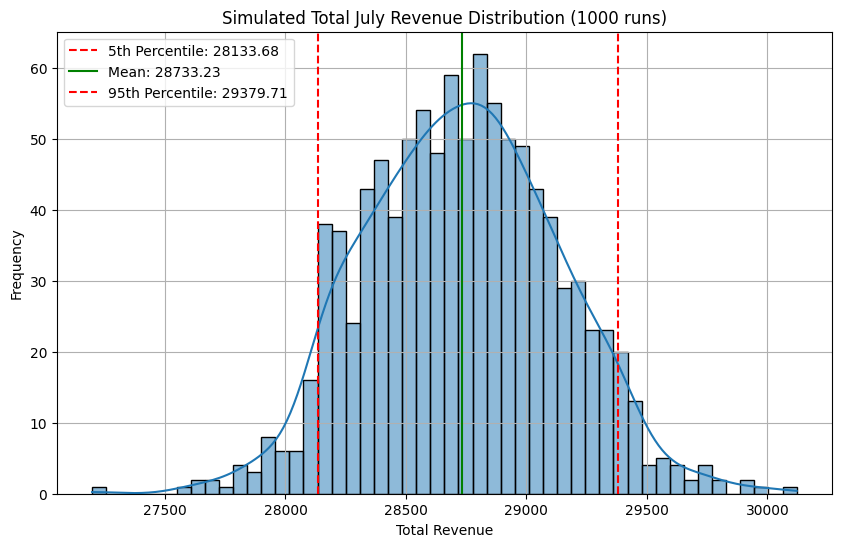

In [118]:
total_revenue_list = []
np.random.seed(42)
X_train_1 =X_train.copy()
continuous_cols = ['viewable_impressions', 'measurable_impressions', 'ratio_meas_total']

for i in range(1000):
    X_sim = X_train_1.sample(n=len(X_train_1), replace=True).reset_index(drop=True)


    for col in continuous_cols:
        noise = np.random.uniform(0.8, 1.2, size=X_sim.shape[0])
        X_sim[col] = X_sim[col] * noise

    X_july_simulated_scaled = scaler.transform(X_sim)

    y_sim_pred = best_xgb.predict(X_july_simulated_scaled)
    total_revenue = y_sim_pred.sum()
    total_revenue_list.append(total_revenue)


total_revenue_array = np.array(total_revenue_list)
mean_total_revenue = total_revenue_array.mean()
lower_bound = np.percentile(total_revenue_array, 5)
upper_bound = np.percentile(total_revenue_array, 95)

print(f"Mean Total Revenue (July): {mean_total_revenue:.2f}")
print(f"5th Percentile (Lower Bound): {lower_bound:.2f}")
print(f"95th Percentile (Upper Bound): {upper_bound:.2f}")

# Step 4: Plot
plt.figure(figsize=(10,6))
sns.histplot(total_revenue_array, bins=50, kde=True)
plt.axvline(lower_bound, color='red', linestyle='--', label=f'5th Percentile: {lower_bound:.2f}')
plt.axvline(mean_total_revenue, color='green', linestyle='-', label=f'Mean: {mean_total_revenue:.2f}')
plt.axvline(upper_bound, color='red', linestyle='--', label=f'95th Percentile: {upper_bound:.2f}')
plt.title('Simulated Total July Revenue Distribution (1000 runs)')
plt.xlabel('Total Revenue')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()


- The July revenue estimates are lower primarily because the simulation introduced 20% random variability, causing many features to shrink rather than grow.

- The XGBoost model is non-linear and sensitive to small changes, so even slight decreases in critical features like impressions or CPM can sharply reduce predicted revenue.

- Bootstrapping samples June data randomly, which can sometimes oversample lower-revenue patterns, naturally pulling the July estimates downward.

In [132]:
df_TRP = df_clean.copy()

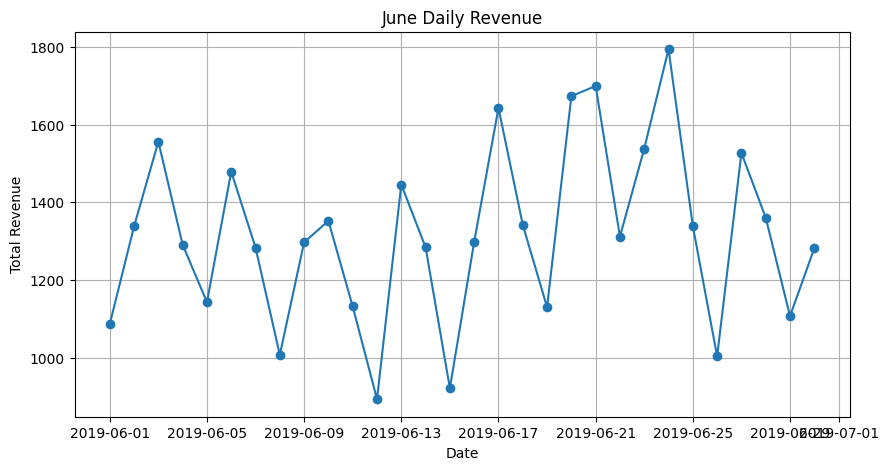

In [138]:
df_TRP =df_TRP[['total_revenue']]
daily_revenue = df_TRP.groupby(df_TRP.index)['total_revenue'].sum()
plt.figure(figsize=(10,5))
plt.plot(daily_revenue, marker='o')
plt.title('June Daily Revenue')
plt.xlabel('Date')
plt.ylabel('Total Revenue')
plt.grid(True)
plt.show()

In [140]:
model = ARIMA(daily_revenue, order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:          total_revenue   No. Observations:                   30
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -200.587
Date:                Sun, 27 Apr 2025   AIC                            407.173
Time:                        15:01:35   BIC                            411.275
Sample:                    06-01-2019   HQIC                           408.458
                         - 06-30-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1320      0.242      0.545      0.585      -0.342       0.606
ma.L1         -0.9977      2.541     -0.393      0.695      -5.977       3.982
sigma2      5.282e+04   1.29e+05      0.410      0.6

c:\Users\mahaj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\mahaj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\mahaj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


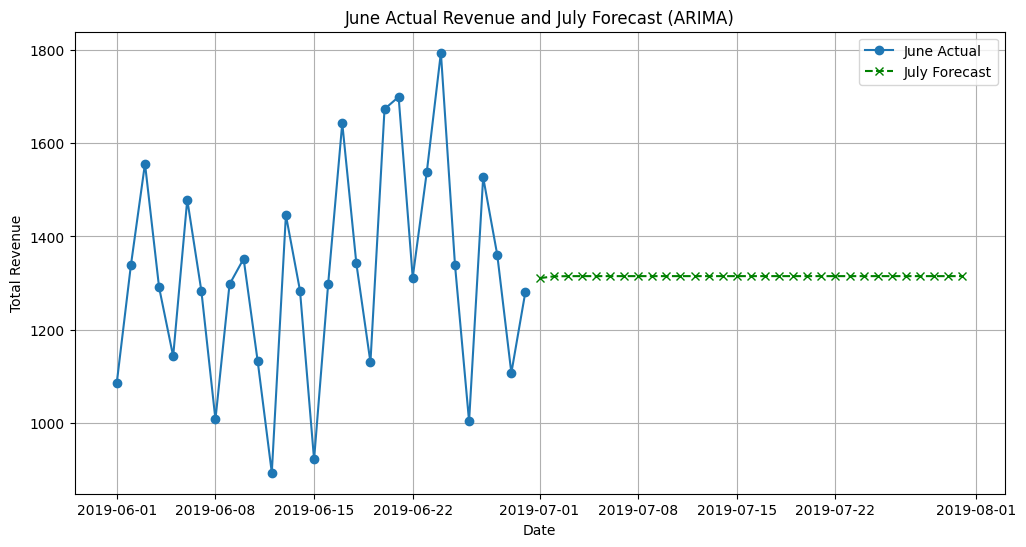

In [142]:
forecast = model_fit.forecast(steps=31)
# Create full timeline
full_dates = pd.date_range(start=daily_revenue.index.min(), periods=len(daily_revenue)+31)

# Combine actual + forecast
full_revenue = pd.concat([daily_revenue, forecast])

plt.figure(figsize=(12,6))
plt.plot(full_dates[:len(daily_revenue)], daily_revenue, marker='o', label='June Actual')
plt.plot(full_dates[len(daily_revenue):], forecast, marker='x', linestyle='--', color='green', label='July Forecast')
plt.title('June Actual Revenue and July Forecast (ARIMA)')
plt.xlabel('Date')
plt.ylabel('Total Revenue')
plt.legend()
plt.grid(True)
plt.show()


The ARIMA(1,1,1) model fitted to the June revenue data assumes that the future revenue will follow a random walk with small adjustments based on previous day's error and previous day's value.<br> It uses one autoregressive term, one differencing operation, and one moving average term.<br> While this simple structure can effectively remove trends and stabilize the time series, it tends to produce overly smooth and flat forecasts when the underlying data is highly volatile.<br> The key limitation of the (1,1,1) model here is its inability to fully capture the rapid day-to-day fluctuations and short-term cyclic patterns present in the June revenue, leading to an unrealistic flat projection for July.

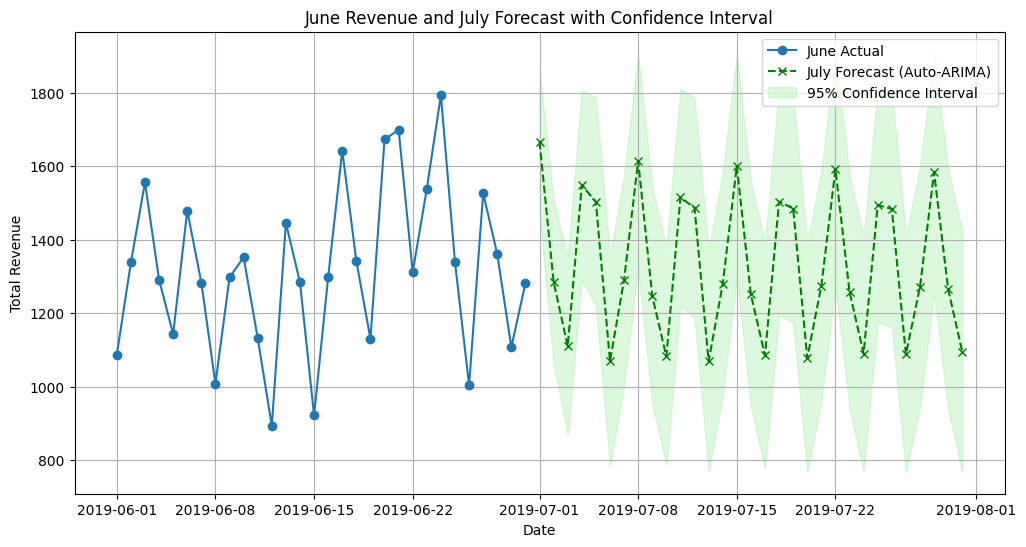

In [151]:


# Auto-select best ARIMA model
model_auto = auto_arima(
    daily_revenue,
    seasonal=False,          # June has no clear seasonality
    stepwise=True,
    suppress_warnings=True
)

# Fit the model
model_auto.fit(daily_revenue)

# Forecast 31 steps
forecast_auto,conf_int  = model_auto.predict(n_periods=31,return_conf_int=True)

# Plot
plt.figure(figsize=(12,6))
future_dates = pd.date_range(start='2019-07-01', periods=31)

# Plot June actuals
plt.plot(daily_revenue.index, daily_revenue, marker='o', label='June Actual')

# Plot July forecast
plt.plot(future_dates, forecast_auto, marker='x', linestyle='--', color='green', label='July Forecast (Auto-ARIMA)')

# Plot confidence interval
plt.fill_between(future_dates, 
                 conf_int[:, 0],    # Lower bound
                 conf_int[:, 1],    # Upper bound
                 color='lightgreen', alpha=0.3, label='95% Confidence Interval')

# Chart styling
plt.title('June Revenue and July Forecast with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Total Revenue')
plt.legend()
plt.grid(True)
plt.show()

In [149]:
total_forecast = forecast_auto.sum()
total_lower_bound = conf_int[:, 0].sum()
total_upper_bound = conf_int[:, 1].sum()

# Print
print(f"Projected Total July Revenue (Auto-ARIMA): {total_forecast:.2f}")
print(f"Projected 95% Confidence Interval: [{total_lower_bound:.2f}, {total_upper_bound:.2f}]")

Projected Total July Revenue (Auto-ARIMA): 41268.74
Projected 95% Confidence Interval: [32037.58, 50499.90]


The projected total July revenue using the Auto-ARIMA model is higher than the actual June revenue.<br> This increase is primarily because the Auto-ARIMA model captures the average revenue level along with daily fluctuations, without modeling any major downward trend from June.<br> Since the June data contained high day-to-day volatility but no strong declining pattern, the model reasonably assumes that July will maintain or slightly exceed the average revenue seen in June.<br> However, the higher projection also reflects the model’s assumption that external market conditions remain stable, without accounting for potential seasonal drops or shifts in advertiser demand.

## What is the reserve prices that he/she can set ?

In [170]:
df_CPM =df_clean.copy().reset_index()
df_CPM =df_CPM.dropna(axis=0)

# Calculate key percentiles
median_cpm = df_CPM['CPM'].median()
percentile_5_cpm = df_CPM['CPM'].quantile(0.05)
percentile_95_cpm = df_CPM['CPM'].quantile(0.95)

# Print
print(f"5th Percentile CPM: {percentile_5_cpm:.2f}")
print(f"Median CPM: {median_cpm:.2f}")
print(f"95th Percentile CPM: {percentile_95_cpm:.2f}")


5th Percentile CPM: 0.00
Median CPM: 0.45
95th Percentile CPM: 7.00


Mean CPM (July): 2.15
CPM 5th-95th Percentile: [2.12, 2.18]


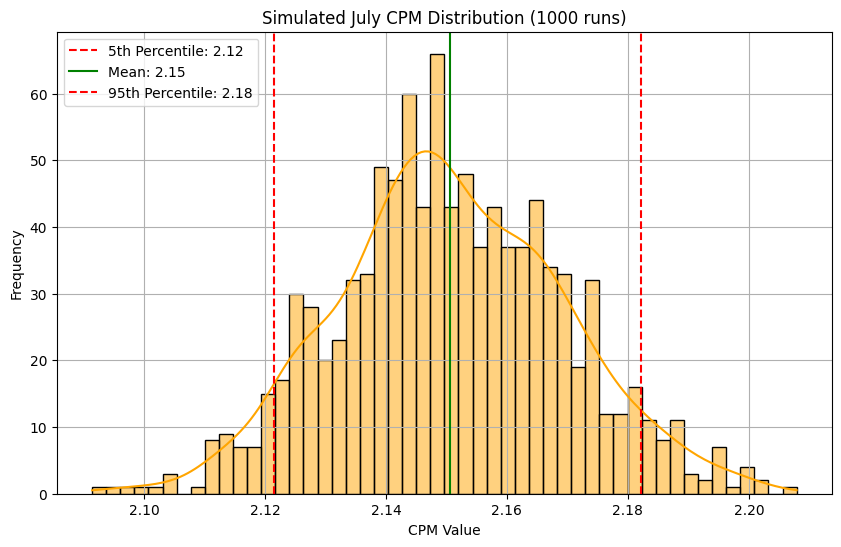

In [160]:
## For one more appraoch we can use model, we have simulated impression and predicted revenue. Calculate CPM using this data 
X_train_1 = X_train.copy()
total_cpm_list = []
continuous_cols = ['viewable_impressions', 'measurable_impressions', 'ratio_meas_total']

# Simulation loop
for i in range(1000):
    # Bootstrap sample
    X_sim = X_train_1.sample(n=len(X_train_1), replace=True).reset_index(drop=True)

    # Add 20% noise to continuous features
    for col in continuous_cols:
        noise = np.random.uniform(0.8, 1.2, size=X_sim.shape[0])
        X_sim[col] = X_sim[col] * noise

    
    X_july_simulated_scaled = scaler.transform(X_sim)
    y_sim_pred = best_xgb.predict(X_july_simulated_scaled)
    total_revenue = y_sim_pred.sum()
    total_measurable_impressions = X_sim['measurable_impressions'].sum()

    if total_measurable_impressions > 0:
        cpm = (total_revenue * 1000) / total_measurable_impressions
    else:
        cpm = np.nan

    total_cpm_list.append(cpm)

# Convert list to array
total_cpm_array = np.array(total_cpm_list)

# CPM statistics
mean_cpm = np.nanmean(total_cpm_array)
lower_bound_cpm = np.nanpercentile(total_cpm_array, 5)
upper_bound_cpm = np.nanpercentile(total_cpm_array, 95)

# Print Results
print(f"Mean CPM (July): {mean_cpm:.2f}")
print(f"CPM 5th-95th Percentile: [{lower_bound_cpm:.2f}, {upper_bound_cpm:.2f}]")

# Plot CPM Distribution
plt.figure(figsize=(10,6))
sns.histplot(total_cpm_array, bins=50, kde=True, color='orange')
plt.axvline(lower_bound_cpm, color='red', linestyle='--', label=f'5th Percentile: {lower_bound_cpm:.2f}')
plt.axvline(mean_cpm, color='green', linestyle='-', label=f'Mean: {mean_cpm:.2f}')
plt.axvline(upper_bound_cpm, color='red', linestyle='--', label=f'95th Percentile: {upper_bound_cpm:.2f}')
plt.title('Simulated July CPM Distribution (1000 runs)')
plt.xlabel('CPM Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

In June data, the CPM distribution was highly skewed, with the 5th percentile at 0.00, median at 0.45, and 95th percentile at 7.00, indicating a wide variation in monetization across impressions.

The June data shows a heavy concentration of low-CPM impressions, with a small portion of very high-CPM impressions pulling the 95th percentile upwards.

In the July simulation using the predictive model, the projected CPM is significantly more stable, with a mean CPM around 2.15 and a very narrow 5th-95th percentile range of [2.12, 2.18].

The model-simulated CPM suggests a much tighter and more consistent revenue expectation compared to the historical June data volatility.

This narrowing of the CPM range reflects that the model learns average behavior but may smooth out extreme low or high CPM cases, leading to more conservative, steady projections for July.